# Predicción del nivel de seguridad de automóviles


Descripción


## Importar librerías


In [33]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Comprobar si category_encoders está instalado, si no, instalarlo de forma silenciosa
%pip install -q category_encoders

import category_encoders as ce

Note: you may need to restart the kernel to use updated packages.


# Cargar los datos


In [34]:
ROOT = Path(os.getenv("PYTHONPATH"))

data = ROOT / "data" / "car_evaluation.csv"

df = pd.read_csv(data, header=None)

## Análisis Exploratorio


In [35]:
print("Primeros 5 registros del dataset:")
print(df.head())

Primeros 5 registros del dataset:
       0      1  2  3      4     5      6
0  vhigh  vhigh  2  2  small   low  unacc
1  vhigh  vhigh  2  2  small   med  unacc
2  vhigh  vhigh  2  2  small  high  unacc
3  vhigh  vhigh  2  2    med   low  unacc
4  vhigh  vhigh  2  2    med   med  unacc


Las columnas no tienen nombres, así que les asignamos uno a cada una.


In [36]:
nombres_columnas = [
    "precio",
    "mantenimiento",
    "puertas",
    "personas",
    "maletero",
    "seguridad",
    "clase",
]

df.columns = nombres_columnas

nombres_columnas

['precio',
 'mantenimiento',
 'puertas',
 'personas',
 'maletero',
 'seguridad',
 'clase']

In [37]:
df.head()

,precio,mantenimiento,puertas,personas,maletero,seguridad,clase
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [38]:
print("\nInformación del dataset:")
print(df.info())


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   precio         1728 non-null   object
 1   mantenimiento  1728 non-null   object
 2   puertas        1728 non-null   object
 3   personas       1728 non-null   object
 4   maletero       1728 non-null   object
 5   seguridad      1728 non-null   object
 6   clase          1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB
None


Distribución de frecuencias


In [39]:
for columna in nombres_columnas:
    print("Distribución de la columna '{}':".format(columna))
    print(df[columna].value_counts())
    print()

Distribución de la columna 'precio':
precio
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64

Distribución de la columna 'mantenimiento':
mantenimiento
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64

Distribución de la columna 'puertas':
puertas
2        432
3        432
4        432
5more    432
Name: count, dtype: int64

Distribución de la columna 'personas':
personas
2       576
4       576
more    576
Name: count, dtype: int64

Distribución de la columna 'maletero':
maletero
small    576
med      576
big      576
Name: count, dtype: int64

Distribución de la columna 'seguridad':
seguridad
low     576
med     576
high    576
Name: count, dtype: int64

Distribución de la columna 'clase':
clase
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64



Exploramos la variable objetivo "clase"


In [40]:
df["seguridad"].value_counts()

seguridad
low     576
med     576
high    576
Name: count, dtype: int64

Comprobamos valores nulos


In [41]:
df.isnull().sum()

precio           0
mantenimiento    0
puertas          0
personas         0
maletero         0
seguridad        0
clase            0
dtype: int64

Definimos las features y la variable objetivo a trabajar


In [42]:
X = df.drop("seguridad", axis=1)
y = df["seguridad"]

Separamos los datos para entrenamiento y test


In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=46
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1382, 6), (346, 6), (1382,), (346,))

Ingeniería de características

In [44]:
X_train.dtypes

precio           object
mantenimiento    object
puertas          object
personas         object
maletero         object
clase            object
dtype: object

In [45]:
X_train.head()

,precio,mantenimiento,puertas,personas,maletero,clase
991,med,high,2,more,small,unacc
1649,low,low,3,2,small,unacc
148,vhigh,high,3,4,med,unacc
732,high,med,5more,2,med,unacc
88,vhigh,vhigh,5more,2,big,unacc


In [46]:
encoder = ce.OrdinalEncoder(cols=["precio", "mantenimiento", "puertas", "personas", "maletero", "clase"])

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [47]:
X_train.head()

,precio,mantenimiento,puertas,personas,maletero,clase
991,1,1,1,1,1,1
1649,2,2,2,2,1,1
148,3,1,2,3,2,1
732,4,3,3,2,2,1
88,3,4,3,2,3,1


In [48]:
X_test.head()

,precio,mantenimiento,puertas,personas,maletero,clase
1330,2,4,2,2,3,1
597,4,1,4,2,2,1
309,3,3,3,3,2,1
612,4,1,4,1,1,1
1267,1,2,4,1,3,3


## Árboles de decición

### Modelo 1

In [49]:
# Semilla para reproducibilidad del modelo 1

seed = 42

np.random.seed(seed)

# Definimos un primer árbol de decisión sin hiperparámetros

model1 = DecisionTreeClassifier(random_state=seed)
model1.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

In [50]:
# Predecimos con el conjunto de prueba de forma aleatoria (3 muestras) en bucle y convertimos las predicciones a etiquetas originales. Además mostramos el valor real.

for i in range(3):
    muestra = X_test.sample(n=1, random_state=i)
    prediccion = model1.predict(muestra)
    print("Muestra:", muestra)
    print("Predicción de seguridad:", prediccion[0])
    print("Valor real de seguridad:", y_test.loc[muestra.index[0]])

Muestra:       precio  mantenimiento  puertas  personas  maletero  clase
1079       1              1        3         1         3      2
Predicción de seguridad: med
Valor real de seguridad: high
Muestra:      precio  mantenimiento  puertas  personas  maletero  clase
942       1              4        4         1         3      1
Predicción de seguridad: low
Valor real de seguridad: low
Muestra:      precio  mantenimiento  puertas  personas  maletero  clase
265       3              3        2         1         2      2
Predicción de seguridad: high
Valor real de seguridad: med


In [51]:
# Métricas de evaluación del modelo ROC AUC

y_pred = model1.predict(X_test)
y_proba = model1.predict_proba(X_test)

roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.4503898210626964


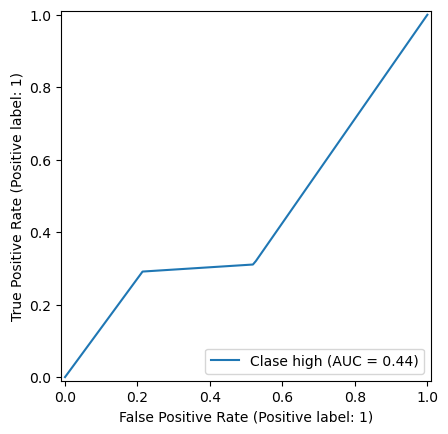

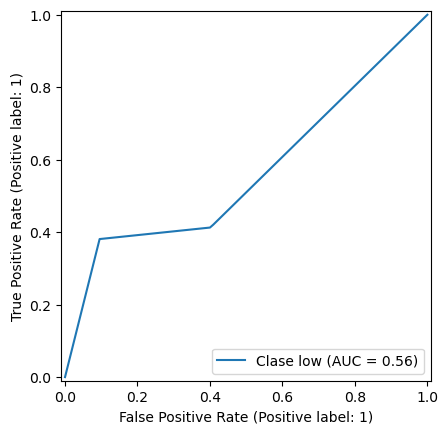

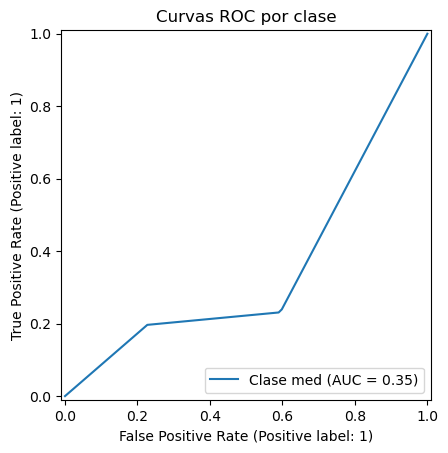

In [52]:
# Visualización de las curvas ROC para cada clase (multiclase)
from sklearn.preprocessing import label_binarize

# Obtener las clases
clases = model1.classes_
# Binarizar las etiquetas verdaderas
y_test_bin = label_binarize(y_test, classes=clases)

# Graficar la curva ROC para cada clase
for i, clase in enumerate(clases):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_proba[:, i],
        name=f"Clase {clase}",
    )
plt.title("Curvas ROC por clase")
plt.show()

### Modelo 2

In [53]:
# Semilla para reproducibilidad del modelo 2
seed = 42

np.random.seed(seed)

# Modelo 2 con el número máximo de hojas que puede tener un árbol de decisión
model2 = DecisionTreeClassifier(max_leaf_nodes=None, random_state=seed)
model2.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

In [54]:
for i in range(3):
    muestra = X_test.sample(n=1, random_state=i)
    prediccion = model2.predict(muestra)
    print("Muestra:", muestra)
    print("Predicción de seguridad:", prediccion[0])
    print("Valor real de seguridad:", y_test.loc[muestra.index[0]])

Muestra:       precio  mantenimiento  puertas  personas  maletero  clase
1079       1              1        3         1         3      2
Predicción de seguridad: med
Valor real de seguridad: high
Muestra:      precio  mantenimiento  puertas  personas  maletero  clase
942       1              4        4         1         3      1
Predicción de seguridad: low
Valor real de seguridad: low
Muestra:      precio  mantenimiento  puertas  personas  maletero  clase
265       3              3        2         1         2      2
Predicción de seguridad: high
Valor real de seguridad: med


In [55]:
# Métricas ROC AUC
y_pred2 = model2.predict(X_test)
y_proba2 = model2.predict_proba(X_test)

roc_auc2 = roc_auc_score(y_test, y_proba2, multi_class='ovr')
print("ROC AUC Score del Modelo 2:", roc_auc2)

ROC AUC Score del Modelo 2: 0.4503898210626964


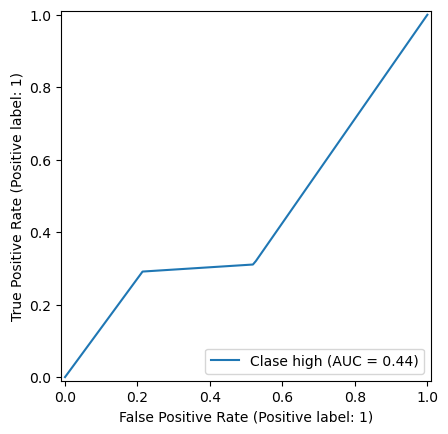

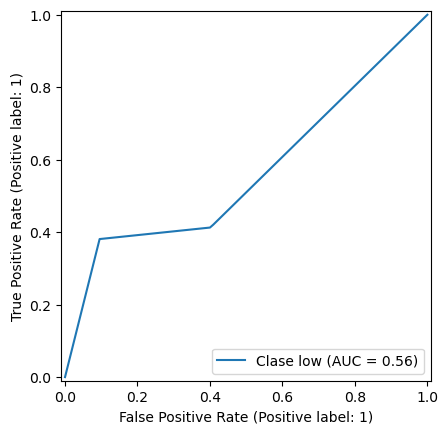

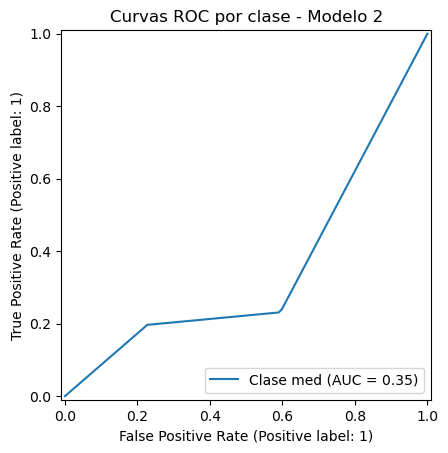

In [56]:
# Visualización de las curvas ROC para cada clase (multiclase) del Modelo 2
# Obtener las clases
clases = model2.classes_
# Binarizar las etiquetas verdaderas
y_test_bin = label_binarize(y_test, classes=clases)
# Graficar la curva ROC para cada clase
for i, clase in enumerate(clases):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_proba2[:, i],
        name=f"Clase {clase}",
    )
plt.title("Curvas ROC por clase - Modelo 2")
plt.show()

### Modelo 3

In [57]:
seed = 42

np.random.seed(seed)

modelo3 = DecisionTreeClassifier(max_leaf_nodes=2, random_state=seed)
modelo3.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",2
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

In [58]:
for i in range(3):
    muestra = X_test.sample(n=1, random_state=i)
    prediccion = modelo3.predict(muestra)
    print("Muestra:", muestra)
    print("Predicción de seguridad:", prediccion[0])
    print("Valor real de seguridad:", y_test.loc[muestra.index[0]])

Muestra:       precio  mantenimiento  puertas  personas  maletero  clase
1079       1              1        3         1         3      2
Predicción de seguridad: high
Valor real de seguridad: high
Muestra:      precio  mantenimiento  puertas  personas  maletero  clase
942       1              4        4         1         3      1
Predicción de seguridad: low
Valor real de seguridad: low
Muestra:      precio  mantenimiento  puertas  personas  maletero  clase
265       3              3        2         1         2      2
Predicción de seguridad: high
Valor real de seguridad: med


In [59]:
# Métricas ROC AUC
y_pred3 = modelo3.predict(X_test)
y_proba3 = modelo3.predict_proba(X_test)

roc_auc3 = roc_auc_score(y_test, y_proba3, multi_class='ovr')
print("ROC AUC Score del Modelo 3:", roc_auc3)

ROC AUC Score del Modelo 3: 0.6741184802435193


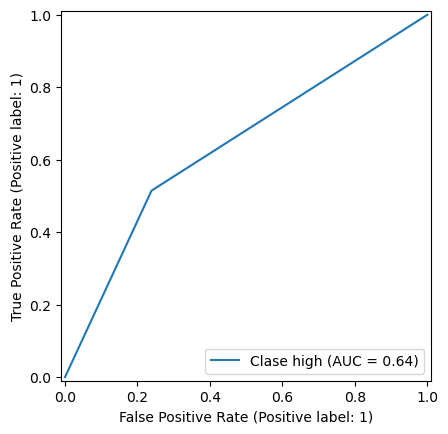

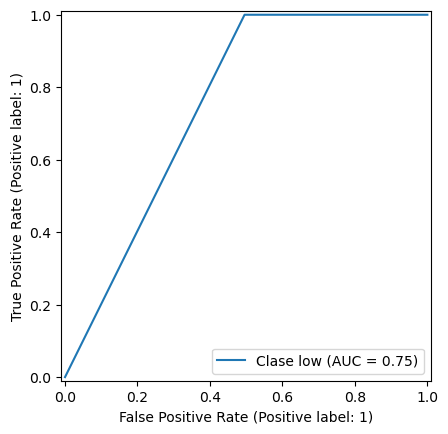

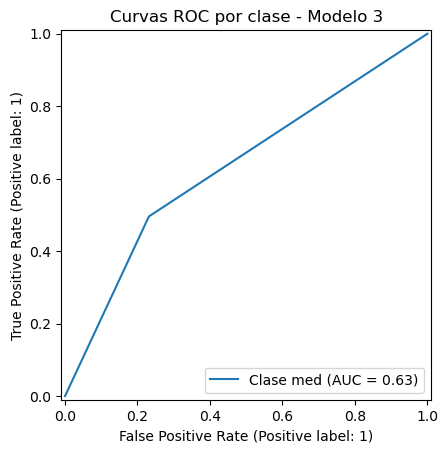

In [60]:
# Visualización de las curvas ROC para cada clase (multiclase) del Modelo 3
# Obtener las clases
clases = modelo3.classes_
# Binarizar las etiquetas verdaderas
y_test_bin = label_binarize(y_test, classes=clases)
# Graficar la curva ROC para cada clase
for i, clase in enumerate(clases):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_proba3[:, i],
        name=f"Clase {clase}",
    )
plt.title("Curvas ROC por clase - Modelo 3")
plt.show()